This notebook concentrates on examining distribution estimates over different site_ids and LOOCV years. It could be divided into the following points:
1. Explore general data distribution for different site_ids
2. Plot 10 best distribution fits for a site_id for a few different LOOCV years
3. Try to find best amendments for results from point 2. 
4. Try to find general amendments that could be added for every year (amendments made for the same distributions for every year) 
5. Examine if all best fitted distributions after revisions represent the data well

It is a version where only cells from 'Plot final distributions only excluding year 2023' are executed to deal with GitHub's 'Sorry, this is too big to display.'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# Go one directory up, to get a parent directory with utils
par_dir = os.path.dirname(os.getcwd())
os.chdir(par_dir)

from utils import ReadAllData, get_outliers, print_summary_outliers_distribution, distr_param_values_to_dict,\
    all_distr_dict

2024-04-13 17:33:03.473 | INFO     | wsfr_read.config:<module>:10 - DATA_ROOT is C:\Users\ja1\Documents\water_supply_forecast_rodeo_competition\data


In [2]:
def plot_distribution_loocv_fold(df_main: pd.DataFrame,
                                 year_cv: int,
                                 n_samples: int = 500,
                                 n_bins: int = 20):
    """
    Plot 10 best fitted distributions from the selected LOOCV fold for
    each site id. Distribution name with its fitted parameters is provided,
    as well as a graph with historical observations and generated samples
    from the distribution.
    
    Args:
        df_main (pd.DataFrame): The main DataFrame
        year_cv (int): LOOCV fold year. Data from this year is excluded
        n_samples (int): How many samples from the distribution should
            be generated. Defaults to 500
        n_bins (int): In how many bins (columns shown on a graph) data.
            should be aggregated. Defaults to 20
    """
    # Load all distributions from this LOOCV fold
    with open(f"data\distr\distr_per_site_{year_cv}", "rb") as fp:
        distr_results = pickle.load(fp)
    # Remove rows from the given CV year
    df = df_main[df_main.year != year_cv].reset_index(drop = True)
    # Remove outliers from the main DataFrame
    OUT_THRES = 2.5
    zscores_outliers = get_outliers(df, OUT_THRES)
    df_with_outliers = df.copy()
    df = df.iloc[~df.index.isin(zscores_outliers.index)].reset_index(drop = True)
    # Transform distributions to a DataFrame
    distr_results = np.array(distr_results, dtype="object")
    distr_results = pd.DataFrame(distr_results)
    distr_results.columns = ['site_id', 'distribution', 'score', 'params']
    distr_results = distr_results.sort_values(
        ['site_id', 'score', 'distribution']).reset_index(drop = True)
    # Get best 10 distributions per site id
    best_fits_site_id = distr_results.groupby('site_id').head(10)
    # Iterate over different site ids
    for idx, site_results in best_fits_site_id.iterrows():
        site_id = site_results['site_id']
        distr = site_results['distribution']
        # Get params in a dictionary
        params = distr_param_values_to_dict(distr,
                                            site_results['params'])
        # Plot distribution name with its fitted parameters
        display([site_id, {distr: params}])
        # Plot fitted distribution
        # Generate n_samples random samples from the fitted distribution.
        # Boundaries are min and max historical values
        x = np.linspace(df[df.site_id == site_id].volume.min(),
                        df[df.site_id == site_id].volume.max(),
                        n_samples)
        # Get PDF for the generated samples
        distr_pdf = all_distr_dict[distr].pdf(x, **params)
        # Plot distribution
        sns.lineplot(x = x,
                     y = distr_pdf,
                     label = 'distr')
        # Plot historical volume data
        sns.histplot(df[df.site_id == site_id].volume,
                     bins = n_bins,
                     label = 'data',
                     kde = True,
                     stat = 'density',
                     linewidth = 0,
                     color = 'darkorange')
        plt.title(f'{distr} distribution for {site_id} from {year_cv}')
        plt.legend()
        plt.show()

In [3]:
def plot_final_distributions(df_main: pd.DataFrame,
                             years_cv: list,
                             n_samples: int = 500,
                             n_bins: int = 20):
    """
    Plot the final distribution from the selected LOOCV folds for each
    site id. The distributions are plotted excluding one LOOCV year at
    a time. Distribution name with its fitted parameters is provided,
    as well as a graph with historical observations and generated samples
    from the distribution.
    
    Args:
        df_main (pd.DataFrame): The main DataFrame
        years_cv (list): LOOCV fold years
        n_samples (int): How many samples from the distribution should
            be generated. Defaults to 500
        n_bins (int): In how many bins (columns shown on a graph) data.
            should be aggregated. Defaults to 20
    """
    # Iterate over different LOOCV years
    for year_cv in years_cv:
        print(f'\n\n{year_cv}')
        # Read best distributions from this year
        with open(f"data\distr\distr_final_{year_cv}", "rb") as fp:
            distr_results_best = pickle.load(fp)
        # Transform distributions to np.ndarray
        distr_results = np.array(distr_results_best, dtype="object")
        # Get site_ids, distribution names and distribution parameters from given year
        site_ids = [x[0] for x in distr_results]
        distributions = [list(x[1].keys())[0] for x in distr_results]
        distr_params = [list(x[1].values())[0] for x in distr_results]
        # Remove rows from given CV year
        df = df_main[df_main.year != year_cv].reset_index(drop = True)
        # Remove outliers from the DataFrame
        OUT_THRES = 2.5
        zscores_outliers = get_outliers(df, OUT_THRES)
        df_with_outliers = df.copy()
        df = df.iloc[~df.index.isin(zscores_outliers.index)]
        # Iterate over site ids and their best distributions
        for site_id, distr, params in zip(site_ids, distributions, distr_params):
            display([site_id, {distr: params}])
            # Plot fitted distribution
            # Generate n_samples random samples from the fitted distribution.
            # Boundaries are min and max historical values
            x = np.linspace(df[df.site_id == site_id].volume.min(),
                            df[df.site_id == site_id].volume.max(),
                            n_samples)
            # Get PDF for the generated samples
            distr_pdf = all_distr_dict[distr].pdf(x, **params)
            # Plot distribution
            sns.lineplot(x = x,
                         y = distr_pdf,
                         label = 'distr')
            # Plot historical volume data
            sns.histplot(df[df.site_id == site_id].volume,
                         bins = n_bins,
                         label = 'data',
                         kde = True,
                         stat = 'density',
                         linewidth = 0,
                         color = 'darkorange')
            plt.title(f'{distr} distribution for {site_id} from {year_cv}')
            plt.legend()
            plt.show()

# Read train data, initialize variables

In [4]:
# Get train df from dfs list
dfs = ReadAllData()
df = dfs.train.copy()
# Get unique site ids
site_ids_unique = dfs.site_ids_unique.copy()
# Remove missing values
df = df[df.volume.notna()].reset_index(drop = True)
# Set outliers threshold
OUT_THRES = 2.5
# Get outliers. It's only for general distribution summary, outliers will
# be removed separately further for each LOOCV year
zscores_outliers = get_outliers(df, OUT_THRES)
# Get the initial DataFrame
df_all_years = df.copy()
# Get a list of LOOCV years
years_cv = [2004,
            2005,
            2006,
            2007,
            2008,
            2009,
            2010,
            2011,
            2012,
            2013,
            2014,
            2015,
            2016,
            2017,
            2018,
            2019,
            2020,
            2021,
            2022,
            2023]

# Data distribution summary

Print outliers and data distribution from the given site_id.

Keep in mind that it is a distribution for full training data (after outliers removal). Distributions are fitted in the next section fo data without LOOCV year from the given fold.

In [ ]:
print_summary_outliers_distribution(df,
                                    site_ids_unique,
                                    zscores_outliers)

# Inspect distributions from a few years and find amendments
Inspect distributions from a few years, select those that require revisions, find better distributions for them.

After inspecting some years, try to choose site_ids that always require distribution and best distributions that generally fit the data well for each date range.

## 2004

In [ ]:
plot_distribution_loocv_fold(df_all_years,
                             2004)

In [ ]:
#Manually selected amendments to make for this year
distr_to_change = [['american_river_folsom_lake',
 {'johnsonsb': {'a': 0.5286881937552037,
   'b': 0.7577430443221962,
   'loc': 131.28795308957874,
   'scale': 2988.9608754647825}}], 
   ['colville_r_at_kettle_falls',
 {'rice': {'b': 0.59068690200198,
   'loc': 7.734204453267276,
   'scale': 85.21041761554818}}],
['missouri_r_at_toston',
 {'gennorm': {'beta': 6.323166819970527,
   'loc': 2055.4377743513915,
   'scale': 1243.4955539841208}}],
['owyhee_r_bl_owyhee_dam', #hard one
 {'gompertz': {'c': 1.8859999095426785,
   'loc': 47.69799999999965,
   'scale': 722.6352383067879}}],
['san_joaquin_river_millerton_reservoir',
 {'triang': {'c': 0.13060122265927798,
   'loc': 109.53311392802243,
   'scale': 3155.1656430676067}}],
['sweetwater_r_nr_alcova', #hard one
 {'triang': {'c': 0.050377082645515756,
   'loc': 5.570068112065901,
   'scale': 174.9591565475746}}],
['virgin_r_at_virtin',
 {'loguniform': {'a': 20.783525691774912,
   'b': 128.37357068710946,
   'loc': -14.641032653740247,
   'scale': 1.4535081784506427}}]]

## 2005

In [ ]:
plot_distribution_loocv_fold(df_all_years,
                             2005)

In [ ]:
#Manually selected amendments to make for this year
distr_to_change = [['american_river_folsom_lake',
 {'johnsonsb': {'a': 0.5695906229326515,
   'b': 0.7664639907445732,
   'loc': 131.6512219420896,
   'scale': 3012.6357386425257}}], 
   ['colville_r_at_kettle_falls',
 {'rice': {'b': 0.5919654553195135,
   'loc': 7.5161733482742115,
   'scale': 85.28447585973254}}],
['fontenelle_reservoir_inflow',
 {'genhalflogistic': {'c': 0.506541051149098,
   'loc': 213.32299999987202,
   'scale': 630.6364882910392}}],
['missouri_r_at_toston',
 {'genhalflogistic': {'c': 0.43853778693640844,
   'loc': 857.4787513108415,
   'scale': 1254.596809821082}}],
['owyhee_r_bl_owyhee_dam', #hard one
 {'gompertz': {'c': 1.969876858231594,
   'loc': 47.69288763245852,
   'scale': 739.0514518030038}}],
['san_joaquin_river_millerton_reservoir',
 {'triang': {'c': 0.13098581001253562,
   'loc': 109.92537958271387,
   'scale': 3142.894794308093}}],
['sweetwater_r_nr_alcova', #hard one
 {'triang': {'c': 0.050396416319766324,
   'loc': 5.5710174480784636,
   'scale': 174.8731992767249}}],
['virgin_r_at_virtin',
 {'loguniform': {'a': 19.38603761105574,
   'b': 115.0176614133398,
   'loc': -14.104746089293862,
   'scale': 1.530614897973349}}]]

## 2006

In [ ]:
plot_distribution_loocv_fold(df_all_years,
                             2006)

In [ ]:
#Manually selected amendments to make for this year
distr_to_change = [['american_river_folsom_lake',
 {'johnsonsb': {'a': 0.6115032164808911,
   'b': 0.7979187419352913,
   'loc': 123.60565717646418,
   'scale': 3056.8191408199114}}], 
   ['colville_r_at_kettle_falls',
 {'rice': {'b': 0.4034728334741913,
   'loc': 7.441622574636475,
   'scale': 88.35251065583205}}],
['missouri_r_at_toston',
 {'genhalflogistic': {'c': 0.441326993198665,
   'loc': 855.4802295120544,
   'scale': 1262.78116810554}}],
['owyhee_r_bl_owyhee_dam', #hard one
 {'gompertz': {'c': 1.7540998151728862,
   'loc': 47.69799999999995,
   'scale': 663.2619575801841}}],
['san_joaquin_river_millerton_reservoir',
 {'triang': {'c': 0.13134507919144528,
   'loc': 110.24716730286607,
   'scale': 3131.84806944751}}],
['sweetwater_r_nr_alcova',
 {'triang': {'c': 0.05037647914845615,
   'loc': 5.570007412072831,
   'scale': 174.96245749414112}}],
['virgin_r_at_virtin',
 {'loguniform': {'a': 20.783525691774912,
   'b': 128.37357068710946,
   'loc': -14.641032653740247,
   'scale': 1.4535081784506427}}]]

## 2007

In [ ]:
plot_distribution_loocv_fold(df_all_years,
                             2007)

In [ ]:
#Manually selected amendments to make for this year
distr_to_change = [['american_river_folsom_lake',
 {'johnsonsb': {'a': 0.5306470490083923,
   'b': 0.7647353455806488,
   'loc': 128.9672835245974,
   'scale': 2998.313744832337}}], 
['colville_r_at_kettle_falls',
 {'rice': {'b': 0.5794290421402455,
   'loc': 7.356559415709398,
   'scale': 85.59964113069192}}],
['fontenelle_reservoir_inflow',
 {'genhalflogistic': {'c': 0.5189885808536173,
   'loc': 213.32299999997608,
   'scale': 642.4117687475346}}],
['missouri_r_at_toston',
 {'gennorm': {'beta': 6.392238689181344,
   'loc': 2051.3001980320296,
   'scale': 1250.168178628182}}],
['owyhee_r_bl_owyhee_dam', #hard one
 {'gompertz': {'c': 1.8130695829284698,
   'loc': 47.69799999999756,
   'scale': 703.9437569333038}}],
['san_joaquin_river_millerton_reservoir',
 {'triang': {'c': 0.13205510794244163,
   'loc': 111.49417878918783,
   'scale': 3152.51585263916}}],
['sweetwater_r_nr_alcova',
 {'triang': {'c': 0.05037301517897509,
   'loc': 5.5698419162536315,
   'scale': 174.97777432484185}}],
['virgin_r_at_virtin',
 {'loguniform': {'a': 20.5533413646773,
   'b': 126.99001365034948,
   'loc': -14.631164158345166,
   'scale': 1.469266431234618}}]]

## 2015

In [ ]:
plot_distribution_loocv_fold(df_all_years,
                             2015)

In [ ]:
#Manually selected amendments to make for this year
distr_to_change = [['colville_r_at_kettle_falls',
 {'rice': {'b': 0.5912659171627659,
   'loc': 7.71065556269293,
   'scale': 85.20978587993892}}],
['detroit_lake_inflow',
 {'genhalflogistic': {'c': 0.5805183201439039,
   'loc': 269.8999999997823,
   'scale': 277.89628960164913}}],
['fontenelle_reservoir_inflow',
 {'genhalflogistic': {'c': 0.5103470458970181,
   'loc': 213.32299999998588,
   'scale': 634.1482239640764}}],
['missouri_r_at_toston',
 {'johnsonsb': {'a': 0.35161368447448715,
   'b': 0.7415501268722937,
   'loc': 780.6255299444831,
   'scale': 2873.707190699971}}],
['owyhee_r_bl_owyhee_dam',
 {'gompertz': {'c': 1.8076096872364449,
   'loc': 47.697999957739235,
   'scale': 702.5182271080873}}],
['san_joaquin_river_millerton_reservoir',
 {'triang': {'c': 0.0726553269397919,
   'loc': 208.55547865060862,
   'scale': 3057.511826125474}}],
['sweetwater_r_nr_alcova',
 {'triang': {'c': 0.050381115639159514,
   'loc': 5.570263562455504,
   'scale': 174.9412716945324}}],
['virgin_r_at_virtin',
 {'loguniform': {'a': 20.55336734461042,
   'b': 126.99025313339946,
   'loc': -14.631135379303341,
   'scale': 1.469263433811252}}]]

# Find general amendments adapted to all years

In [ ]:
#Given site_id distribution will be changed with the distribution below for every year
amendments_site_to_distr_dict = {'american_river_folsom_lake': 'johnsonsb',
                                 'colville_r_at_kettle_falls': 'rice',
                                 'fontenelle_reservoir_inflow': 'genhalflogistic',
                                 'missouri_r_at_toston': 'gennorm',
                                 'owyhee_r_bl_owyhee_dam': 'gompertz',
                                 'san_joaquin_river_millerton_reservoir': 'triang',
                                 'sweetwater_r_nr_alcova': 'triang',
                                 'virgin_r_at_virtin': 'loguniform',
                                 'detroit_lake_inflow': 'anglit'}
# genhalflogistic was selected as best for 2015, which is a year when amendment
# was necessary but for other 4 examined years, anglit was the best working one

# Plot final distributions

In [ ]:
plot_final_distributions(df_all_years,
                         years_cv)

<font color = 'green'>All distributions seem acceptable. Also, their parameters are different for all years, so it seems that removing one year from the DataFrame works.</font>

## Plot final distributions only excluding year 2023
Only distributions used in the last LOOCV fold are plotted, to not get too many graphs. To plot graphs from all LOOCV folds, run the previous cell.



2023


['ruedi_reservoir_inflow',
 {'triang': {'c': 0.4723086828725598,
   'loc': 36.87919514898491,
   'scale': 192.71465493729437}}]

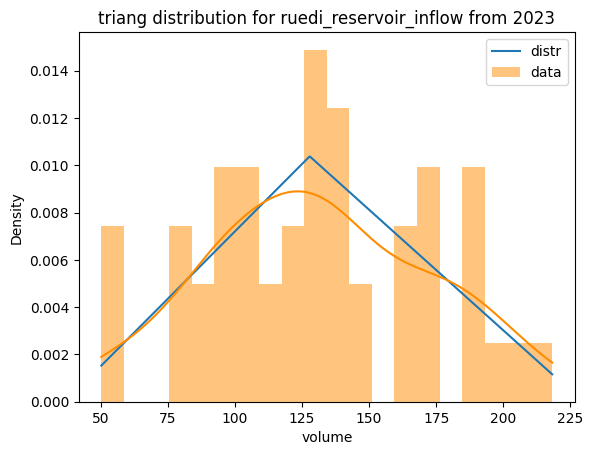

['detroit_lake_inflow',
 {'anglit': {'loc': 466.85992569139864, 'scale': 379.4959851711494}}]

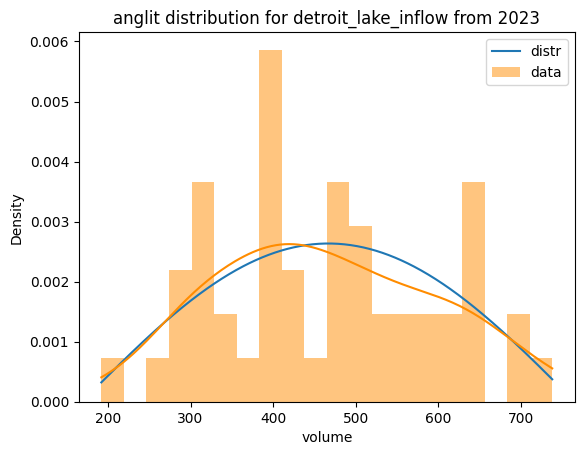

['taylor_park_reservoir_inflow',
 {'triang': {'c': 0.31775773967158716,
   'loc': 29.03629583012995,
   'scale': 148.09616984167855}}]

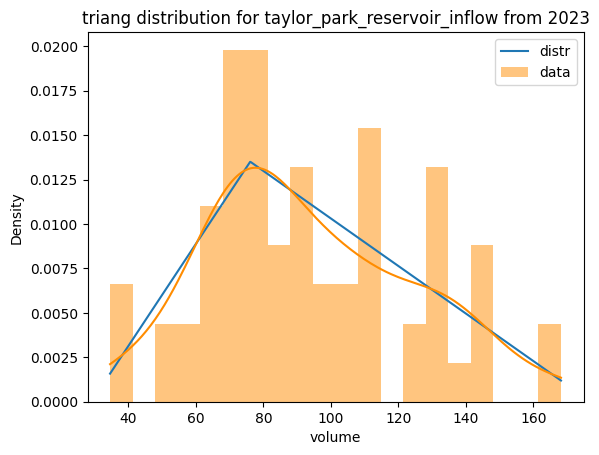

['pueblo_reservoir_inflow',
 {'triang': {'c': 0.4144669566000778,
   'loc': -33.37339054315224,
   'scale': 725.9864405380802}}]

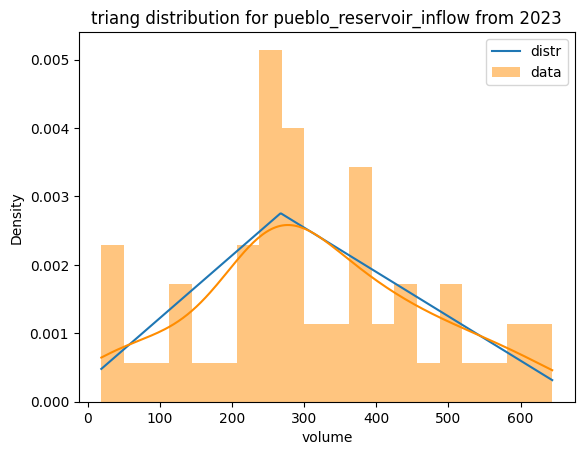

['fontenelle_reservoir_inflow',
 {'genhalflogistic': {'c': 0.5022637642281251,
   'loc': 213.3229999999997,
   'scale': 626.1733075520312}}]

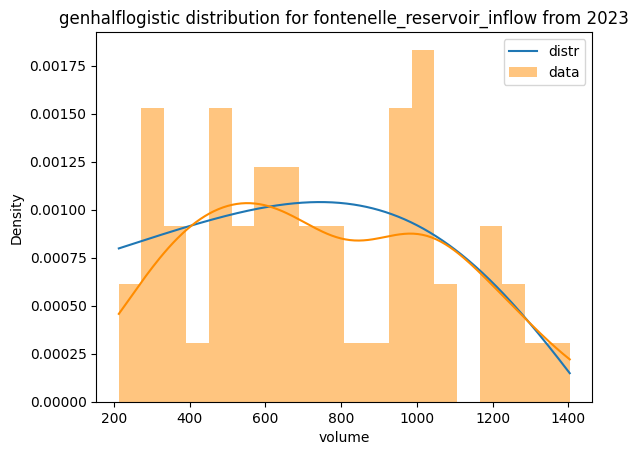

['dillon_reservoir_inflow',
 {'triang': {'c': 0.38622920762170393,
   'loc': 41.33191017513516,
   'scale': 250.50174331655123}}]

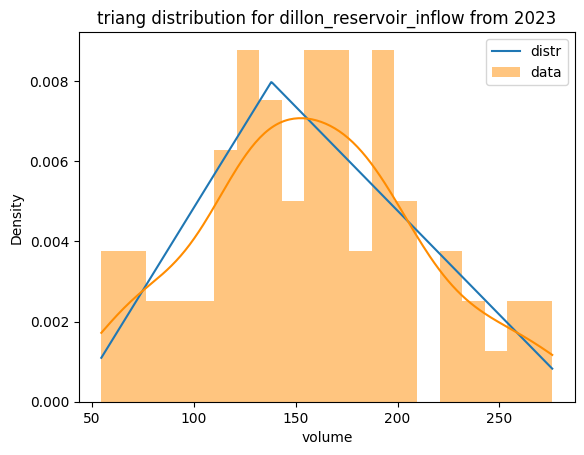

['pecos_r_nr_pecos',
 {'genhalflogistic': {'c': 0.31047507895778503,
   'loc': 7.699999997617063,
   'scale': 40.08884192932797}}]

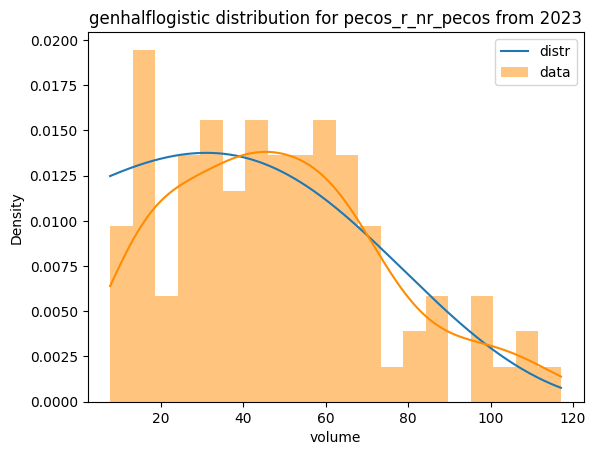

['sweetwater_r_nr_alcova',
 {'triang': {'c': 0.052444388839094566,
   'loc': 5.643298388465592,
   'scale': 166.66609730107763}}]

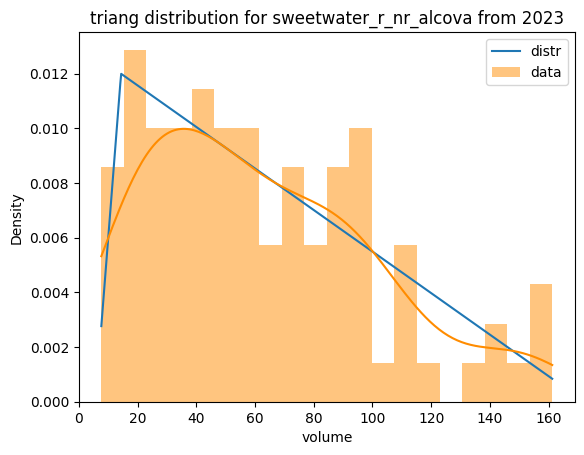

['merced_river_yosemite_at_pohono_bridge',
 {'triang': {'c': 0.14055257057819903,
   'loc': 52.69386752486797,
   'scale': 836.7412420292268}}]

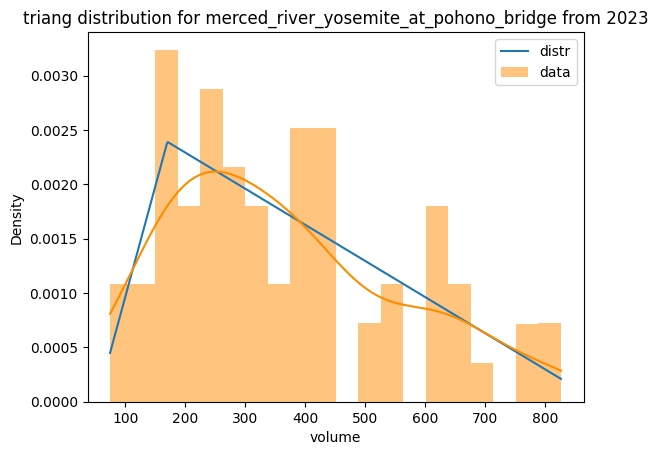

['san_joaquin_river_millerton_reservoir',
 {'triang': {'c': 0.13442531868900182,
   'loc': 112.92195799584705,
   'scale': 3040.1865213252386}}]

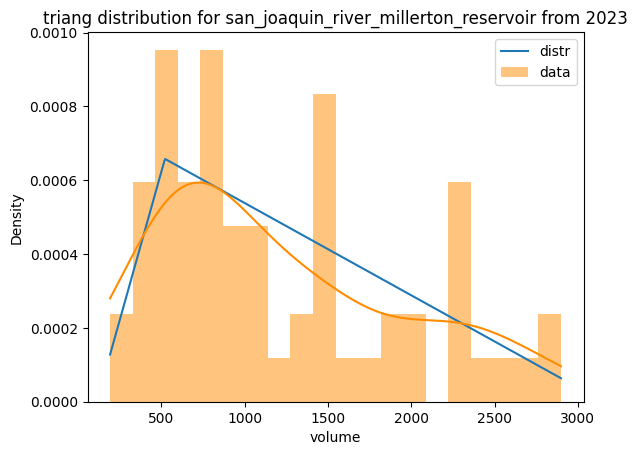

['virgin_r_at_virtin',
 {'loguniform': {'a': 20.3059215928213,
   'b': 125.22904650770067,
   'loc': -14.69737517340348,
   'scale': 1.490455931580986}}]

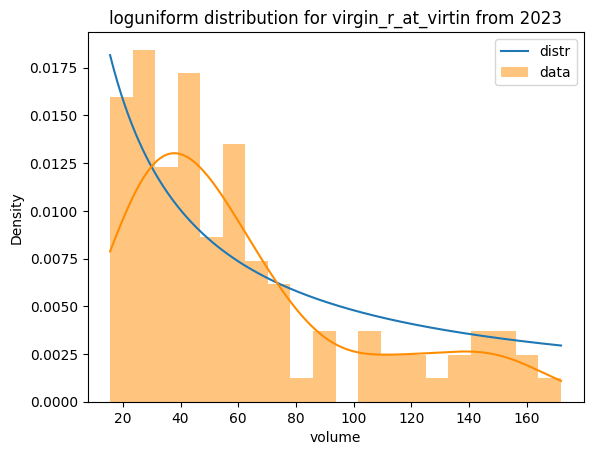

['boysen_reservoir_inflow',
 {'genhalflogistic': {'c': 0.4910694080335502,
   'loc': 110.38399999997932,
   'scale': 634.1167011015614}}]

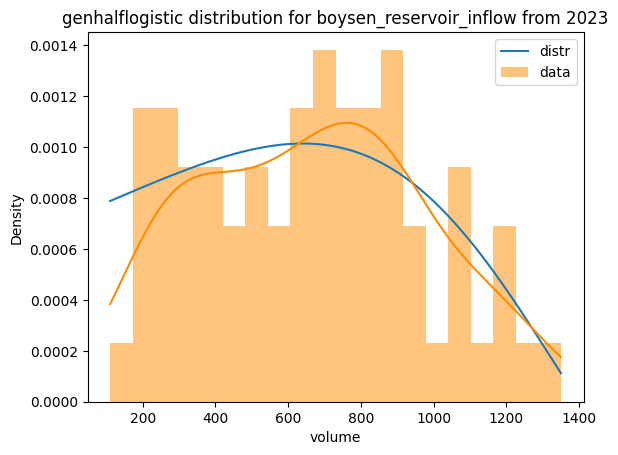

['green_r_bl_howard_a_hanson_dam',
 {'triang': {'c': 0.34549400939895225,
   'loc': 72.76099422182574,
   'scale': 426.8959857650502}}]

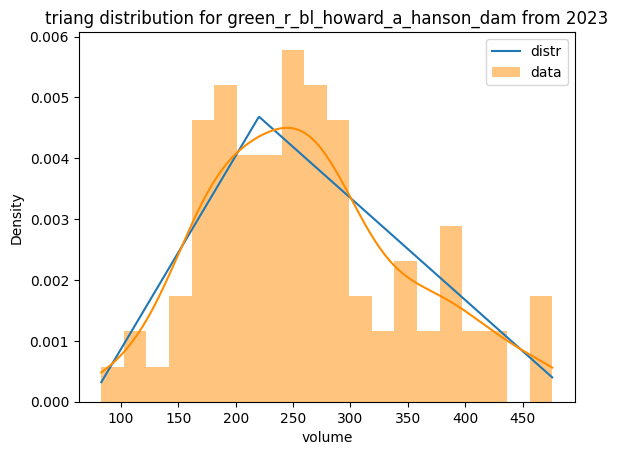

['skagit_ross_reservoir',
 {'triang': {'c': 0.42861907913511554,
   'loc': 572.9617888187609,
   'scale': 1680.1823489352519}}]

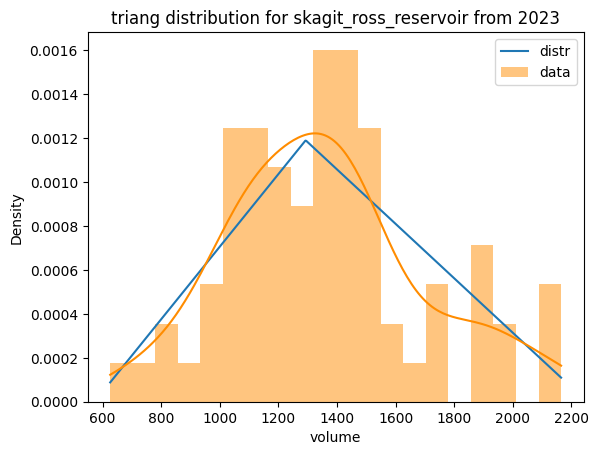

['colville_r_at_kettle_falls',
 {'rice': {'b': 0.47980187782471917,
   'loc': 7.304498024264891,
   'scale': 87.37205803516525}}]

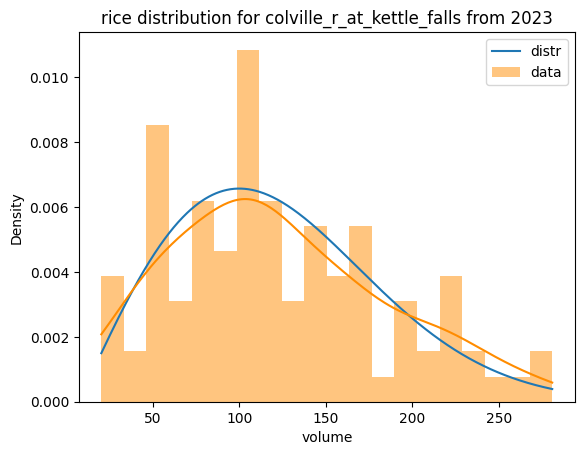

['libby_reservoir_inflow',
 {'triang': {'c': 0.433364061227187,
   'loc': 2623.6900199648862,
   'scale': 6265.018775083001}}]

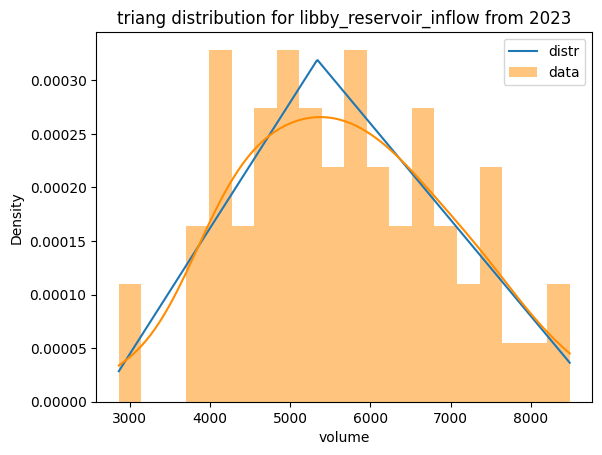

['owyhee_r_bl_owyhee_dam',
 {'gompertz': {'c': 2.0561799408980264,
   'loc': 47.69799999989223,
   'scale': 760.9752865697742}}]

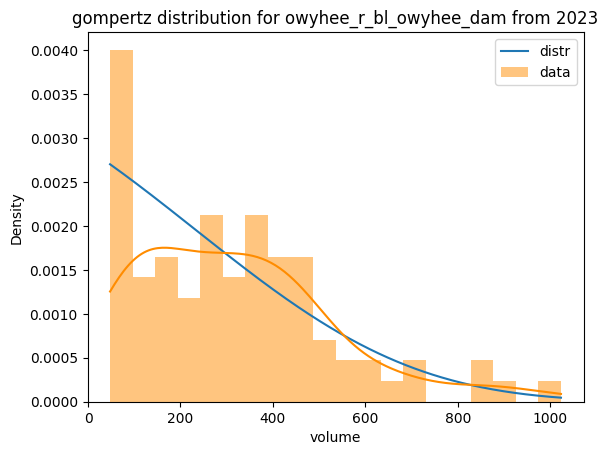

['american_river_folsom_lake',
 {'johnsonsb': {'a': 0.5804506519457044,
   'b': 0.7734397207049911,
   'loc': 130.01711483406615,
   'scale': 3024.5708829969662}}]

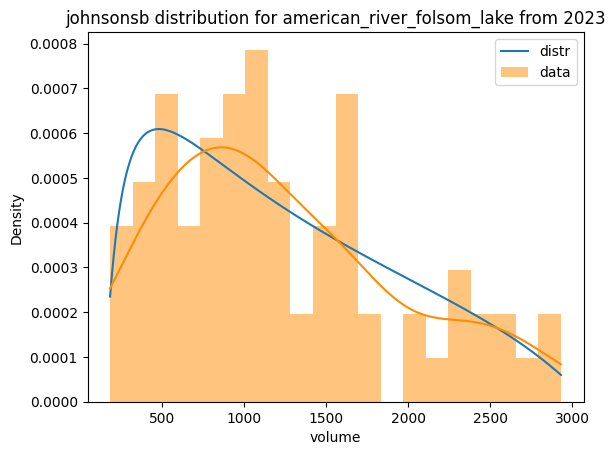

['weber_r_nr_oakley',
 {'foldnorm': {'c': 2.1288697586569807,
   'loc': 34.44194534682413,
   'scale': 38.856920784149224}}]

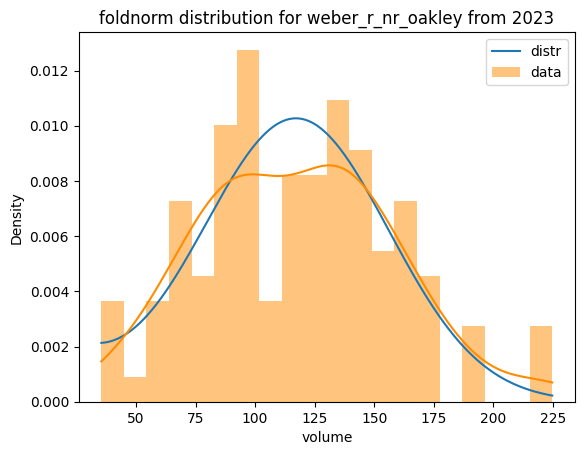

['stehekin_r_at_stehekin',
 {'triang': {'c': 0.5122057136196703,
   'loc': 346.41071008929816,
   'scale': 726.9721520120082}}]

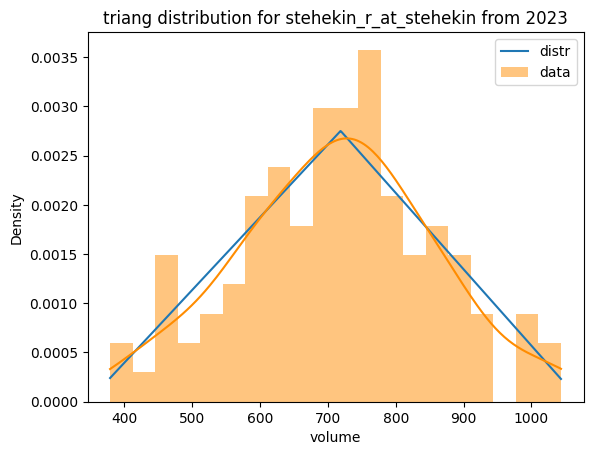

['missouri_r_at_toston',
 {'gennorm': {'beta': 6.827776336633405,
   'loc': 2053.835502666653,
   'scale': 1261.083788218458}}]

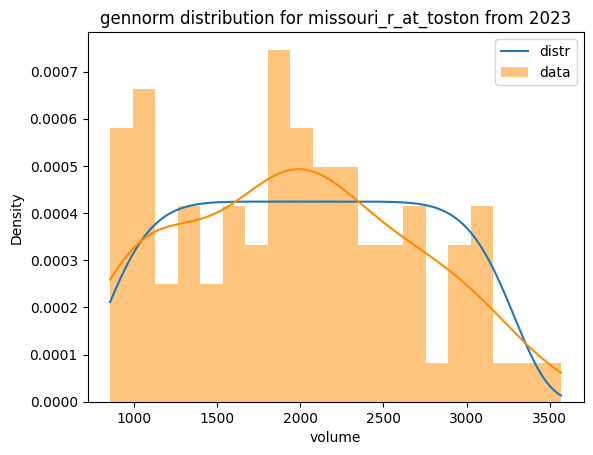

['animas_r_at_durango',
 {'gennorm': {'beta': 4.324334267270433,
   'loc': 431.2221666447234,
   'scale': 278.9078175831163}}]

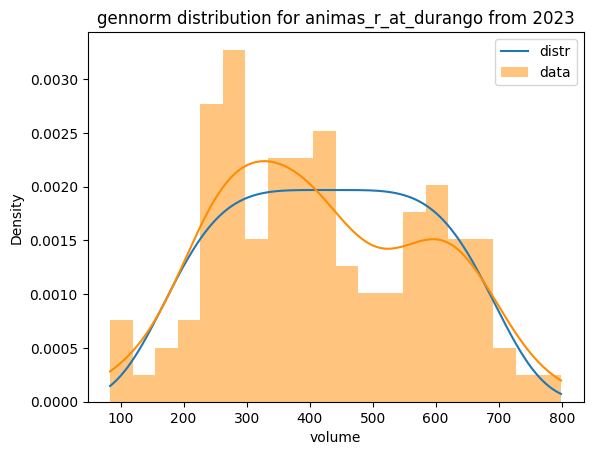

['yampa_r_nr_maybell',
 {'triang': {'c': 0.40112031778492446,
   'loc': 178.90439902878205,
   'scale': 1549.7858707421583}}]

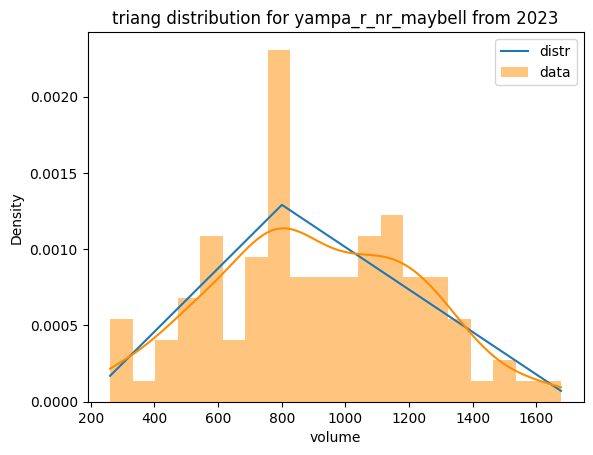

['hungry_horse_reservoir_inflow',
 {'johnsonsb': {'a': 0.534223719644082,
   'b': 1.7136933747395031,
   'loc': 454.47926893866196,
   'scale': 3664.1119345442867}}]

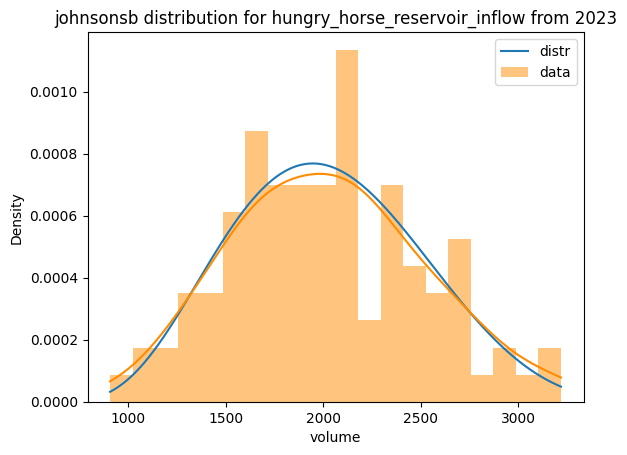

['snake_r_nr_heise',
 {'dweibull': {'c': 1.566783224870017,
   'loc': 3194.459547405032,
   'scale': 887.8502044126787}}]

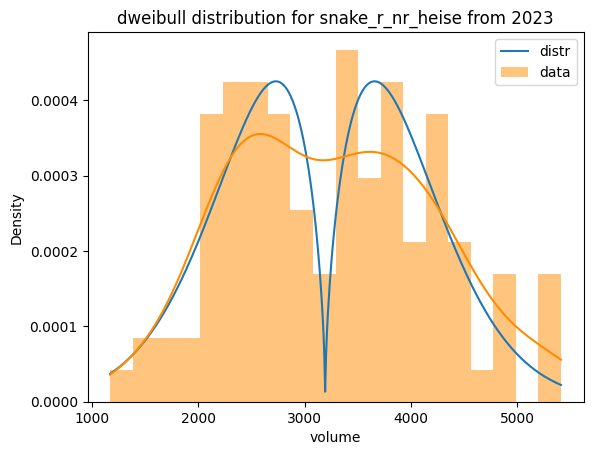

['boise_r_nr_boise',
 {'beta': {'a': 1.80796214766137,
   'b': 2.5186926039143285,
   'loc': 305.1522714359964,
   'scale': 2537.650050281668}}]

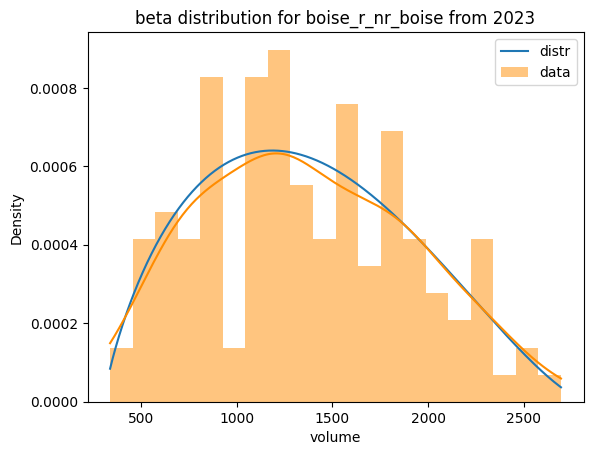

In [5]:
plot_final_distributions(df_all_years,
                         [2023])